In [1]:
import numpy as np
import pandas as pd

np.random.seed(5)
months = 60

# Simulate monthly returns (normally distributed)
asset1 = np.random.normal(0.01, 0.03, months)
asset2 = np.random.normal(0.012, 0.025, months)
asset3 = np.random.normal(0.008, 0.02, months)
asset4 = np.random.normal(0.015, 0.035, months)
# Asset 5 is correlated with asset 1 and 2, plus some noise
asset5 = 0.5*asset1 + 0.3*asset2 + np.random.normal(0.005, 0.01, months)

df = pd.DataFrame({
    'Asset1': asset1,
    'Asset2': asset2,
    'Asset3': asset3,
    'Asset4': asset4,
    'Asset5': asset5
})

df.head()


,Asset1,Asset2,Asset3,Asset4,Asset5
0,0.023237,0.001107,0.037015,0.048469,0.013194
1,0.000074,0.036304,0.020137,-0.007348,0.016275
2,0.082923,0.005982,0.000488,0.009991,0.048707
3,0.002437,-0.008603,-0.020438,0.007153,-0.004000
4,0.013288,0.026203,-0.027623,-0.021347,0.016374


In [2]:
import statsmodels.api as sm

# Prepare predictors (X) and target (y)
X = df[['Asset1', 'Asset2', 'Asset3', 'Asset4']]
y = df['Asset5']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Asset5   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     49.42
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           1.39e-17
Time:                        15:08:41   Log-Likelihood:                 197.99
No. Observations:                  60   AIC:                            -386.0
Df Residuals:                      55   BIC:                            -375.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.960      0.0

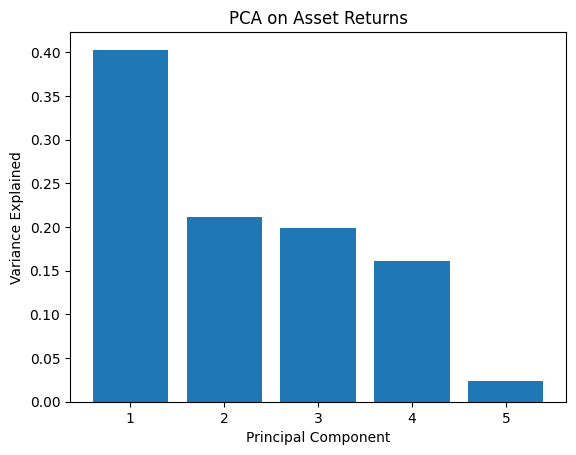

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Standardize data before PCA (mean=0, std=1)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_returns = scaler.fit_transform(df)

# Fit PCA (keep all components)
pca = PCA()
pca.fit(scaled_returns)

# Explained variance ratio
explained_var = pca.explained_variance_ratio_

# Plot
plt.bar(range(1, len(explained_var)+1), explained_var)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA on Asset Returns')
plt.show()


In [4]:
# Check component loadings

print("PCA Component Loadings (weights for each asset):")
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(5)],
                        index=[f'Asset{i+1}' for i in range(5)])
print(loadings)


PCA Component Loadings (weights for each asset):
             PC1       PC2       PC3       PC4       PC5
Asset1  0.577880 -0.202357 -0.271277 -0.457516 -0.584974
Asset2  0.439137  0.362692  0.271432  0.689100 -0.356482
Asset3 -0.098392  0.846033  0.164938 -0.490394 -0.082807
Asset4  0.095318 -0.317172  0.907292 -0.258702 -0.014536
Asset5  0.674127  0.105531 -0.048482 -0.091691  0.723642


Optimal Portfolio Weights:
Asset 1: 6.99%
Asset 2: 1.56%
Asset 3: 31.93%
Asset 4: 12.27%
Asset 5: 47.25%
Expected return: 1.24%
Risk (stdev): 1.31%
Sharpe ratio: 0.94


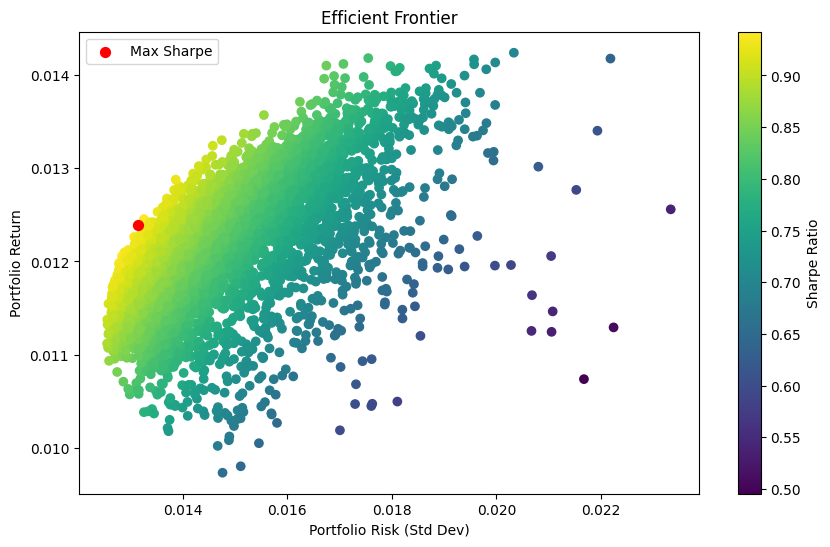

In [5]:
# Mean-variance Optimization

mean_returns = df.mean()
cov_matrix = df.cov()
num_assets = len(mean_returns)
num_portfolios = 5000

results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    # Random weights for each asset
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)

    # Portfolio return and risk
    port_return = np.dot(weights, mean_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    # Sharpe Ratio (risk-free rate assumed 0)
    sharpe_ratio = port_return / port_std

    results[0,i] = port_return
    results[1,i] = port_std
    results[2,i] = sharpe_ratio

# Find the portfolio with the highest Sharpe ratio
max_sharpe_idx = np.argmax(results[2])
optimal_weights = weights_record[max_sharpe_idx]

print("Optimal Portfolio Weights:")
for i, w in enumerate(optimal_weights):
    print(f"Asset {i+1}: {w:.2%}")

print(f"Expected return: {results[0,max_sharpe_idx]:.2%}")
print(f"Risk (stdev): {results[1,max_sharpe_idx]:.2%}")
print(f"Sharpe ratio: {results[2,max_sharpe_idx]:.2f}")

# Plot the efficient frontier
plt.figure(figsize=(10,6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
plt.xlabel('Portfolio Risk (Std Dev)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results[1,max_sharpe_idx], results[0,max_sharpe_idx], c='red', s=50, label='Max Sharpe')
plt.legend()
plt.show()
